<a href="https://colab.research.google.com/github/david-j-cox/twitter-higher-ed/blob/main/sentiment_dabl_analyses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages and modules

In [85]:
import numpy as np
from numpy import std, mean, sqrt
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats
from google.colab import files
try:
  import dabl
except:
  !pip install dabl
  import dabl
try:
  from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
except:
  !pip install vaderSentiment
from textblob import TextBlob
from textblob import Blobber
try:
  import sweetviz as sv
except:
    !pip install sweetviz
    import sweetviz as sv
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/gdrive')
%cd './gdrive/My Drive/Twitter-Higher-Ed/'

# Data read in, drop duplicates, and merging

In [ ]:
# Read in pre-COVID tweets, drop duplicates and save. 
raw_data_pre = pd.read_csv('./01_raw/pre_covid_learning.csv')
raw_data_pre = raw_data_pre.drop_duplicates()
raw_data_pre.to_csv('./01_raw/pre_covid_learning.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,9,10,11,12,13,23,29) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Keep only the columns with information related to COVID or higher-education
cov_list = ['covid', 'covid-19', 'covid19', 'coronavirus', 'corona virus'] 
hied_list = ['college', 'university', 'professor', 'teacher', 'higher ed', 'higher education']

In [ ]:
# Convert all the text to lowercase for string matching
raw_data_pre['content'] = raw_data_pre['content'].str.lower()

In [ ]:
# Create a list of the indices containing Tweets with COVID or higher-education
int_keep_pre = []

for i in range(len(raw_data_pre)):
  val = str(raw_data_pre['content'][i])
  for j in hied_list:
    if j in val:
      if i in int_keep_pre:
        continue
      else:
        int_keep_pre.append(i)

int_keep_pre = pd.DataFrame(int_keep_pre)
int_keep_pre.columns = ['index']
int_keep_pre.to_csv('./02_intermediate/ints_pre.csv')
print("raw total:", len(raw_data_pre))

# Use the list of the indices to trim the raw df
df_pre = raw_data_pre.iloc[int_keep_pre['index']]
print("subset total: ", len(df_pre))
df_pre = df_pre.reset_index(drop=True)
df_pre.to_csv('./02_intermediate/clean_pre.csv')

In [ ]:
# Read in post-COVID tweets, drop duplicates and save
raw_data_post = pd.read_csv('./01_raw/post_covid_learning.csv')
print("Pre: ", len(raw_data_post))
raw_data_post = raw_data_post.drop_duplicates()
print("Post: ", len(raw_data_post))
raw_data_post.to_csv('./01_raw/post_covid_learning.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,9,10,11,12,13,23,29) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Convert all the text to lowercase for string matching
raw_data_post['content'] = raw_data_post['content'].str.lower()

In [ ]:
# Create a list of the indices containing Tweets with COVID or higher-education
int_keep_post = []

for i in range(len(raw_data_post)):
  val = str(raw_data_post['content'][i])
  for j in hied_list:
    for k in cov_list:
      if j in val:
        if i in int_keep_post:
          continue
        else:
          int_keep_post.append(i)
      if k in val:
        if i in int_keep_post:
          continue
        else:
          int_keep_post.append(i)

int_keep_post = pd.DataFrame(int_keep_post)
int_keep_post.columns = ['index']
int_keep_post.to_csv('./02_intermediate/ints_post.csv')
print("raw total:", len(raw_data_post))

# Use the list of the indices to trim the raw df
df_post = raw_data_post.iloc[int_keep_post['index']]
print("subset total: ", len(df_post))
df_post = df_post.reset_index(drop=True)
df_post.to_csv('./02_intermediate/clean_post.csv')

raw total: 2034546
subset total:  71547


In [32]:
# Combine the pre and post dfs into a single dataframe
all_data = df_pre.append(df_post)
all_data = all_data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
all_data = all_data.reset_index(drop=True)
all_data.to_csv('./02_intermediate/all_data.csv')

# Sentiment Analysis using Vader model

In [33]:
# Add sentiment scores from Vader Model
san = SentimentIntensityAnalyzer()
pos = []
neu = []
neg = []
compound = []

for i in range(len(all_data)):
  sent_dict = san.polarity_scores(all_data['content'][i])
  pos.append(sent_dict.get('pos'))
  neu.append(sent_dict.get('neu'))
  neg.append(sent_dict.get('neg'))
  compound.append(sent_dict.get('compound'))

all_data['vader_pos'] = pos
all_data['vader_neu'] = neu
all_data['vader_neg'] = neg
all_data['vader_com'] = compound

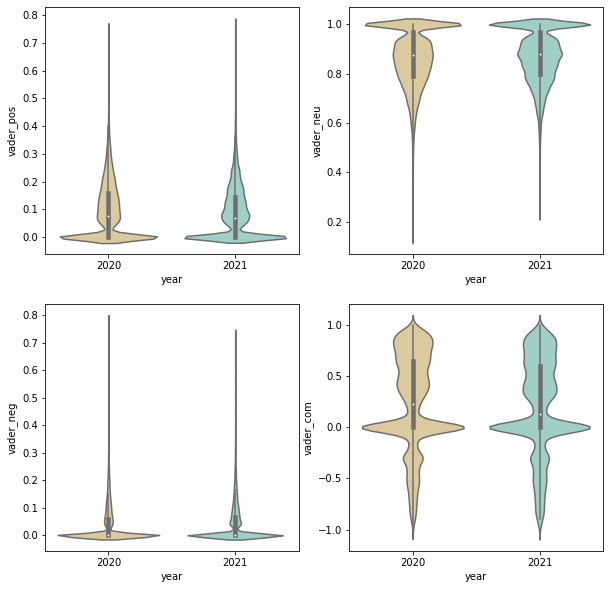

In [94]:
# Quick plots of Vader sentiment before and after
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
sns.violinplot(x=all_data['year'], y=all_data['vader_pos'], ax=axs[0, 0], palette="BrBG")
sns.violinplot(x=all_data['year'], y=all_data['vader_neu'], ax=axs[0, 1], palette="BrBG")
sns.violinplot(x=all_data['year'], y=all_data['vader_neg'], ax=axs[1, 0], palette="BrBG")
sns.violinplot(x=all_data['year'], y=all_data['vader_com'], ax=axs[1, 1], palette="BrBG")
plt.savefig(fname='./figures/violin_vader.png', bbox_inches='tight')
plt.show()

In [95]:
# Descriptions of sentiment by year
vader_desc = pd.DataFrame(all_data['vader_pos'][all_data['year']==2020].describe())
vader_desc.columns = ['pos_2020']

vader_desc['pos_2021'] = all_data['vader_pos'][all_data['year']==2021].describe()

for i in ['vader_neu', 'vader_neg', 'vader_com']:
  for year in [2020, 2021]:
    name = i[-3:]+"_"+str(year)
    vader_desc[name] = all_data[i][all_data['year']==year].describe()

vader_desc.to_csv('./03_primary/vader_descriptions.csv')
vader_desc

,pos_2020,pos_2021,neu_2020,neu_2021,neg_2020,neg_2021,com_2020,com_2021
count,83801.000000,71547.000000,83801.000000,71547.000000,83801.000000,71547.000000,83801.000000,71547.000000
mean,0.096064,0.086573,0.864826,0.871476,0.039108,0.041950,0.233092,0.189437
std,0.101571,0.093072,0.113945,0.109236,0.070509,0.070044,0.465153,0.462588
min,0.000000,0.000000,0.137000,0.232000,0.000000,0.000000,-0.997100,-0.997300
25%,0.000000,0.000000,0.791000,0.800000,0.000000,0.000000,0.000000,0.000000
50%,0.076000,0.069000,0.875000,0.881000,0.000000,0.000000,0.226300,0.128000
75%,0.161000,0.144000,0.969000,0.969000,0.060000,0.067000,0.647900,0.593950
max,0.750000,0.768000,1.000000,1.000000,0.787000,0.733000,0.998700,0.997400


In [93]:
# Statistics on the differences
comparison = []
stat = []
p_val = []
coh_d = []

for i in ['vader_pos', 'vader_neu', 'vader_neg', 'vader_com']:
  comparison.append(i)
  ttest = stats.ttest_ind(all_data[i][all_data['year']==2020], all_data[i][all_data['year']==2021])
  stat.append(ttest[0])
  p_val.append(ttest[1])
  c0 = all_data[i][all_data['year']==2020]
  c1 = all_data[i][all_data['year']==2021]
  coh_d.append((mean(c0) - mean(c1)) / (sqrt((std(c0) ** 2 + std(c1) ** 2) / 2)))

vader_stats = pd.DataFrame([comparison, stat, p_val, coh_d])
vader_stats = vader_stats.transpose()
vader_stats.columns = ['comparison', 't_stat', 'p_val', 'cohens_d']
vader_stats.to_csv('./03_primary/vader_stats.csv')
vader_stats

,comparison,t_stat,p_val,cohens_d
0,vader_pos,19.0754,5.00964e-81,0.0974308
1,vader_neu,-11.6854,1.55977e-31,-0.0595801
2,vader_neg,-7.94168,2.00779e-15,-0.0404353
3,vader_com,18.4844,3.32995e-76,0.0941099


# Sentiment Analysis using TextBlob

In [141]:
# Add sentiment scores from NB and Pattern Model
polarity = []
subjectivity = []

for i in range(len(all_data)):
  sent_dict = TextBlob(all_data['content'][i]).sentiment
  polarity.append(sent_dict[0])
  subjectivity.append(sent_dict[1])

all_data['text_blob_polarity'] = polarity
all_data['text_blob_subjectivity'] = subjectivity

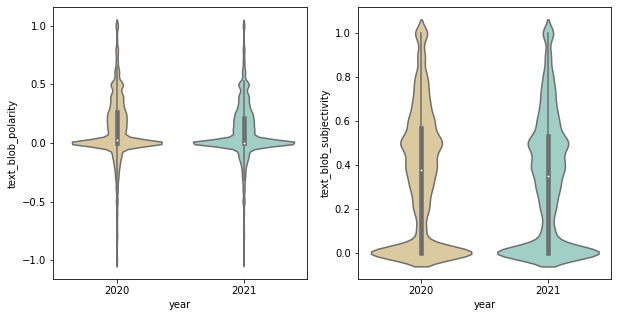

In [142]:
# Quick plots of TextBlob sentiment before and after
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.violinplot(x=all_data['year'], y=all_data['text_blob_polarity'], ax=axs[0], palette="BrBG")
sns.violinplot(x=all_data['year'], y=all_data['text_blob_subjectivity'], ax=axs[1], palette="BrBG")
plt.savefig(fname='./figures/violin_textblob.png', bbox_inches='tight')
plt.show()

In [143]:
# Descriptions of sentiment by year
txblb_desc = pd.DataFrame(all_data['text_blob_polarity'][all_data['year']==2020].describe())
txblb_desc.columns = ['txblb_polarity_2020']

txblb_desc['txblb_polarity_2021'] = all_data['text_blob_polarity'][all_data['year']==2021].describe()
txblb_desc['txblb_subjectivity_2020'] = all_data['text_blob_subjectivity'][all_data['year']==2020].describe()
txblb_desc['txblb_subjectivity_2021'] = all_data['text_blob_subjectivity'][all_data['year']==2021].describe()

txblb_desc.to_csv('./03_primary/textblob_descriptions.csv')
txblb_desc

,txblb_polarity_2020,txblb_polarity_2021,txblb_subjectivity_2020,txblb_subjectivity_2021
count,83801.000000,71547.000000,83801.000000,71547.000000
mean,0.124602,0.097276,0.356113,0.335782
std,0.259888,0.235628,0.296717,0.289982
min,-1.000000,-1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.025000,0.000000,0.375000,0.350000
75%,0.263889,0.212121,0.566667,0.533333
max,1.000000,1.000000,1.000000,1.000000


In [144]:
# Statistics on the differences
comparison = []
stat = []
p_val = []
coh_d = []

for i in ['text_blob_polarity', 'text_blob_subjectivity']:
  comparison.append(i)
  ttest = stats.ttest_ind(all_data[i][all_data['year']==2020], all_data[i][all_data['year']==2021])
  stat.append(ttest[0])
  p_val.append(ttest[1])
  c0 = all_data[i][all_data['year']==2020]
  c1 = all_data[i][all_data['year']==2021]
  coh_d.append((mean(c0) - mean(c1)) / (sqrt((std(c0) ** 2 + std(c1) ** 2) / 2)))

txblb_stats = pd.DataFrame([comparison, stat, p_val, coh_d])
txblb_stats = txblb_stats.transpose()
txblb_stats.columns = ['comparison', 't_stat', 'p_val', 'cohens_d']
txblb_stats.to_csv('./03_primary/txblb_stats.csv')
txblb_stats

,comparison,t_stat,p_val,cohens_d
0,text_blob_polarity,21.5591,6.15791e-103,0.110162
1,text_blob_subjectivity,13.6031,4.0596e-42,0.0693051


In [146]:
# Correlation matrix
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm", \
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction", ha='center', \
                va='center', fontsize=font_size)

def annotate_colname(x, **kws):
    ax = plt.gca()
    ax.annotate(x.name, xy=(0.05, 0.9), xycoords=ax.transAxes, fontweight='bold')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


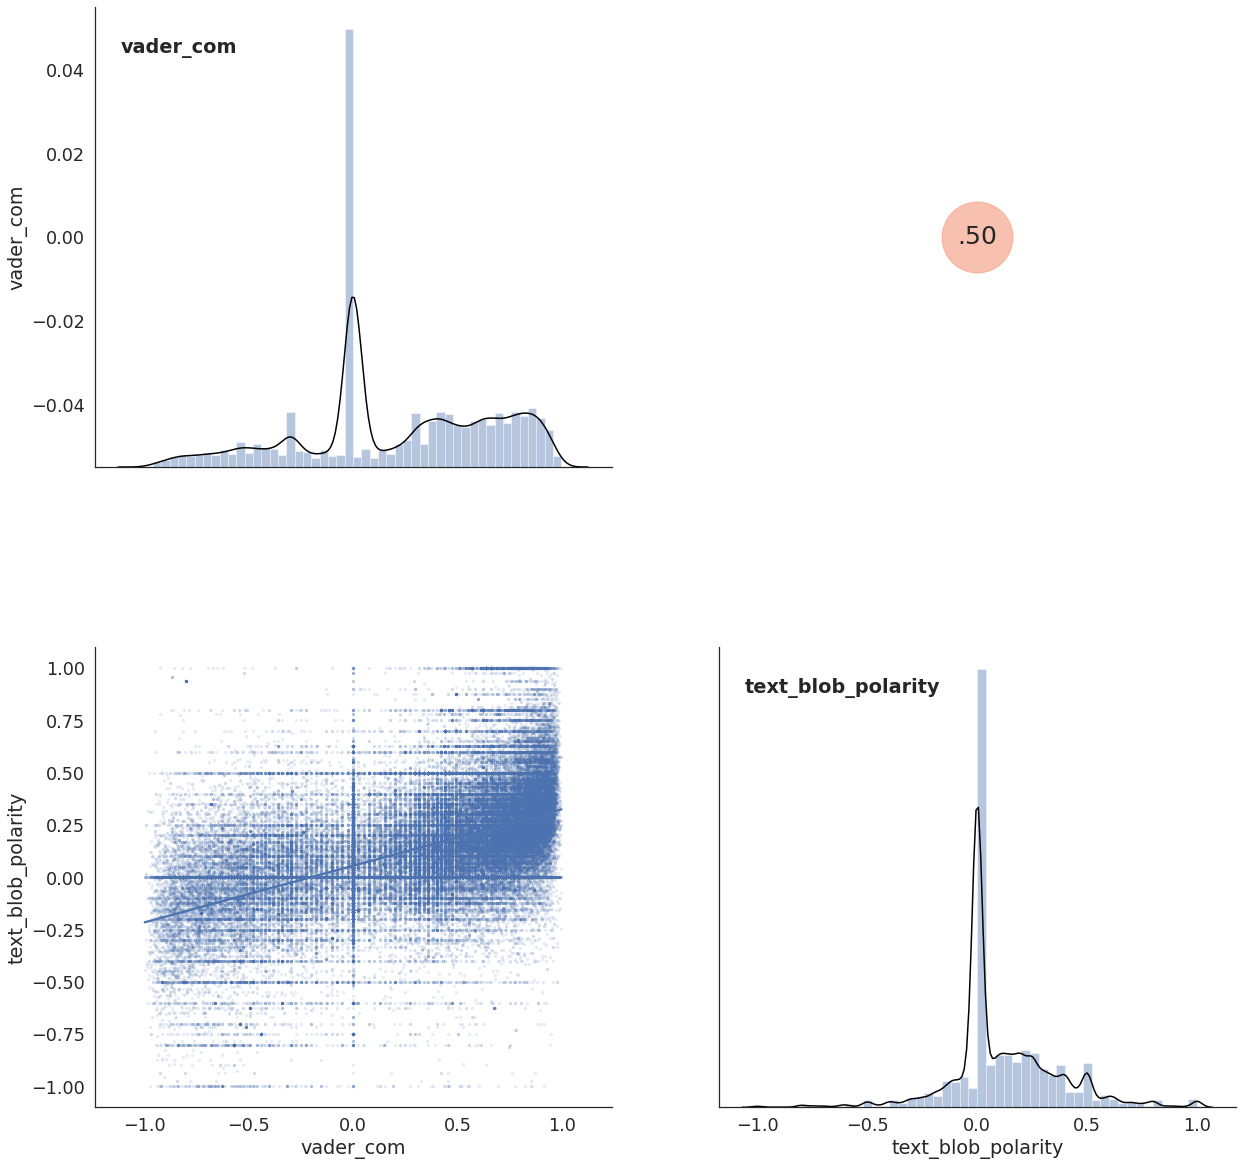

In [158]:
section_df = all_data[['vader_com', 'text_blob_polarity']]

# Plot visual
sns.set(style='white', font_scale=1.6)
g = sns.PairGrid(section_df, aspect=1.4, diag_sharey=False)
g.fig.set_size_inches(20,20)
g.map_lower(sns.regplot, scatter_kws={'s':5,'alpha':0.1})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_diag(annotate_colname)
g.map_upper(corrdot)
plt.savefig(fname='./figures/sentiment_corr_matrix.png', bbox_inches='tight')
plt.show()

# Playing with dabl

In [ ]:
dabl_df = dabl.clean(all_data, verbose=1)

Detected feature types:
continuous      10
dirty_float      5
low_card_int     0
categorical      7
date             0
free_string     13
useless          4
dtype: int64


## Clean-up some features

In [ ]:
df_clean = df_clean.drop(['Unnamed: 0.1_ @PMOIndia @AmitShah @drharshvardhan @IMAIndiaOrg @ANI',\
                         'Unnamed: 0.1_#MedTwitter #MedStudentTwitter #MedEd #AcademicChatter #AcademicTwitter',\
                         'Unnamed: 0.1_#MedTwitter #PeruvianPhysiciansCrew',\
                         'Unnamed: 0.1_#SelfDefenceIsLegal',
                         'Unnamed: 0.1_#たてたてよこよこ横山結衣 #ディズニーランド #Disney #初調査員 #あべこうじ #横山結衣 #中村かさね #藤原祐輝 #木邨将太 #服部未佳 #土曜日 #９時３５分 #青森 #夢はここから #生放送 #ハッピィ #土曜日 #9時35分 #ABA #青森朝日放送 #aomori https://t.co/On0xqhbqoX',
                         'Unnamed: 0.1_1-70 dias', 'Unnamed: 0.1_1-dos meses ',
                         'Unnamed: 0.1_1-tres meses ', 'Unnamed: 0.1_2-Maracay Estado Aragua ',
                         'Unnamed: 0.1_3- #ABA cantv reporte No 19650849',
                         'Unnamed: 0.1_3- #ABA cantv reporte No 19650849 l',
                         "Unnamed: 0.1_D govt they're waiting on for help is actually d one killing them",
                         'Unnamed: 0.1_cortados durante la Cuarentena. Nos engañan o que?',
                         'Unnamed: 0.1_por falta de pago. Y no hay manera de pagarlo xqse debe pagar en Zoom y ellos no estan trabajando. ES UN ABUSO DE CANTV',
                         'Unnamed: 0.1_dabl_continuous'], axis=1)

# Save it
df_clean.to_csv('aba_twitter_sentiment_dabl_clean.csv')

In [ ]:
# If picking up fresh
raw_data = pd.read_csv('aba_twitter_sentiment_dabl_clean.csv')
df_clean = raw_data.copy()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df_clean = df_clean.drop(['Unnamed: 0'], axis=1)

## Quick plots

In [ ]:
# All data
dabl.plot(df_clean, target_col='compound')

In [ ]:
# Isolate bx Twitter
df_bx = df_clean[df_clean['focus']!= 'medtwitter']

In [ ]:
# Bx twitter only
dabl.plot(df_bx, target_col='compound')

In [ ]:
# Medtwitter
df_med = df_clean[df_clean['focus']== 'medtwitter']

In [ ]:
df_med = df_med.drop(['_type', 'url','id', 'user', 'conversationId','source',
                      'sourceUrl', 'sourceLabel', 'outlinks', 'tcooutlinks',
                      'media', 'retweetedTweet', 'quotedTweet', 'inReplyToTweetId',
                      'inReplyToUser', 'hashtags', 'cashtags'], axis=1)

In [ ]:
for i in list(df_med):
  print(i, df_med[i].unique(), "\n")

In [ ]:
# Cleanup some of the count features
int_list = ['replyCount', 'retweetCount', 'likeCount', 'quoteCount']

for i in int_list:
  df_med[i] = df_med[i].astype(float)

In [ ]:
# Plot it
dabl.plot(df_med, target_col='compound')

In [ ]:
plt.scatter(x=df_med['likeCount'], y=df_med['compound'], s=7, alpha=0.05)
plt.xlim(-10, 275)
plt.yticks(ticks=[-1, -0.5, 0, 0.5, 1])

## Tweets with and without emoji conversion to text

In [ ]:
df_trimmed = df_clean[['pos', 'neu', 'neg', 'compound', 
                      'pos_e', 'neu_e', 'neg_e', 'compound_e']]
df_trimmed = df_trimmed.reset_index(drop=True)

In [ ]:
keep = []

for i in range(len(df_trimmed)):
  if df_trimmed['pos'][i] - df_trimmed['pos_e'][i]==0:
    if df_trimmed['neu'][i] - df_trimmed['neu_e'][i]==0:
      if df_trimmed['neg'][i] - df_trimmed['neg_e'][i]==0:
        if df_trimmed['compound'][i] - df_trimmed['compound_e'][i]==0:
          keep.append('no')
        else:
          keep.append("yes")
      else:
          keep.append("yes")
    else:
          keep.append("yes")
  else:
    keep.append("yes")

df_trimmed['keep'] = keep

In [ ]:
df_trimmed = df_trimmed[df_trimmed['keep']=='yes']
df_trimmed = df_trimmed.drop(['keep'], axis=1)
df_trimmed = df_trimmed.reset_index(drop=True)

In [ ]:
len(df_trimmed)

91638

In [ ]:
# Functions we need
# Functions
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm", \
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction", ha='center', \
                va='center', fontsize=font_size)

def annotate_colname(x, **kws):
    ax = plt.gca()
    ax.annotate(x.name, xy=(0.05, 0.9), xycoords=ax.transAxes, fontweight='bold')

def reg_plot(df,y,x,title=None,x_label=None,y_label=None,save_name=None, y_max=None, y_min=None):
    fig, ax = plt.subplots(figsize=(5,5))
    ax = sns.regplot(x=x, 
                     y=y, 
                     data=df, 
                     color='k')
    sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=True, trim=False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.set_ylabel(f'{y_label}', fontsize=20)
    ax.set_xlabel(f'{x_label}',fontsize=20)
    ax.set_ylim([y_min,y_max])
    # plt.suptitle(f'{title}')
    # plt.tight_layout()
    plt.savefig(save_name, bbox_inches='tight')
    plt.show()

In [ ]:
# Crazy plots
import warnings
warnings.filterwarnings('ignore')
sns.set(style='white', font_scale=1.6)
g = sns.PairGrid(df_trimmed, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, scatter_kws={'s':10})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_diag(annotate_colname)
g.map_upper(corrdot) 
plt.show()

## Sweetviz for comparisons

In [ ]:
df_bx['inReplyToTweetId'] = df_bx['inReplyToTweetId'].replace("['ABA']", np.nan)
df_bx['inReplyToTweetId'] = df_bx['inReplyToTweetId'].replace("['たてたてよこよこ横山結衣', 'ディズニーランド', 'Disney', '初調査員', 'あべこうじ', '横山結衣', '中村かさね', '藤原祐輝', '木邨将太', '服部未佳', '土曜日', '９時３５分', '青森', '夢はここから', '生放送', 'ハッピィ', '土曜日', '9時35分', 'ABA', '青森朝日放送', 'aomori']", np.nan)
df_bx['inReplyToTweetId'] = df_bx['inReplyToTweetId'].replace("['RT', 'ABA']", np.nan)
df_bx['inReplyToTweetId'] = df_bx['inReplyToTweetId'].replace("['Aba', 'SelfDefenceIsLegal']", np.nan)
df_bx['inReplyToTweetId'] = df_bx['inReplyToTweetId'].replace("['LatinosInMedicine', 'LatinxInMedicine', 'MedTwitter', 'PeruvianPhysiciansCrew']", np.nan)
df_bx['inReplyToTweetId'] = df_bx['inReplyToTweetId'].replace("['MedTwitter', 'MedStudentTwitter', 'MedEd', 'AcademicChatter', 'AcademicTwitter']", np.nan)
df_bx['inReplyToTweetId'] = df_bx['inReplyToTweetId'].replace("['StopViolenceAgainstDoctors', 'Medtwitter', 'iStandWithDoctors', 'NoToViolenceOnDoctors']", np.nan)
df_bx['inReplyToTweetId'] = df_bx['inReplyToTweetId'].astype(float)

In [ ]:
# Bx twitter vs. medtwitter
compare_report = sv.compare([df_bx, "Behavior Twitter"], [df_med, "Med Twitter"])
compare_report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## Change in sentiment over time

In [ ]:
# Make sure all datetimes are as they need to be
df_bx = df_bx.reset_index(drop=True)
new_date = []
for i in range(len(df_bx)):
  date = df_bx['date'][i]
  try:
    val = pd.to_datetime(date)
    new_date.append(val)
  except:
    print(date)
    new_val = input()
    new_val = pd.to_datetime(new_val)
    new_date.append(new_val)

df_bx['date'] = new_date

In [ ]:
# Sort dfs by date for plotting
# behavior analysis
df_bx = df_bx.sort_values(by=['date'])
df_bx = df_bx.dropna(subset=['date'])
df_bx = df_bx.reset_index(drop=True)

# med
df_med = df_med.sort_values(by=['date'])
df_med = df_med.dropna(subset=['date'])
df_med = df_med.reset_index(drop=True)

In [ ]:
# Plot them
plt.figure(figsize=(20,10))
plt.scatter(x=df_bx['date'], y=df_bx['compound'], color='blue', alpha=0.05)
plt.scatter(x=df_med['date'], y=df_med['compound'], color='red', alpha=0.007)
plt.show()

In [ ]:
# Aggregate by month and year
def aggregate(df):
  df['date'] = pd.to_datetime(df['date'], errors='coerce')
  df['year'] = pd.DatetimeIndex(df['date']).year
  df['month'] = pd.DatetimeIndex(df['date']).month
  testing = df.groupby(by=['year', 'month']).mean()
  testing = testing.reset_index()
  testing['year'] = testing['year'].astype(str)
  testing['month'] = testing['month'].astype(str)
  testing['year_month'] = testing['year'] + "-" + testing['month']
  return testing

agg_bx = aggregate(df_bx)
agg_med = aggregate(df_med)

In [ ]:
agg_bx = agg_bx.drop(0).reset_index(drop=True)

In [ ]:
# Plot them
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(x=agg_bx['year_month'], y=agg_bx['compound'], color='blue', s=50, alpha=0.5)
sns.scatterplot(x=agg_med['year_month'], y=agg_med['compound'], color='red', s=50, alpha=0.5)
sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=True, trim=False)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
plt.ylim(0, 0.3)
plt.yticks(fontsize=20)
plt.ylabel('Sentiment Score', fontsize=26, labelpad=30)
plt.xlabel('Date', fontsize=26, labelpad=30)
plt.xticks(rotation=90, fontsize=16)
plt.show()

In [ ]:
df_bx[]